In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.sparse as sps
from statsmodels.api import Logit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, confusion_matrix

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import sklearn

Here the results from 'Adult EDA" file are going to be used

In [2]:
# %run "Adult EDA.ipynb"

In [3]:
adult_columns = [
    "Age",
    "Workclass",
    "final weight",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Income",
]

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
                 header = None, names = adult_columns)

In [4]:
df = df.drop(['Education-Num'], axis = 'columns')

In [5]:
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country']

In [6]:
# for col in categorical_features_list:
#     print(f'{col}\n{df[col].value_counts()}\n')

As in the whole dataset (X) we have only one 'Holand-Netherlands' value in 'Country' column, we have to process it separately, because in case if it appears in the test set, model will not be able to predict target for such a record. For the initial model, where there are no changes in data, this observation will be removed

In [7]:
print(df.shape)
df_no_nl = df.copy()
df_no_nl.drop(df_no_nl.loc[df['Country']==' Holand-Netherlands'].index, inplace=True)
print(df_no_nl.shape)

(32561, 14)
(32560, 14)


In [8]:
X = df_no_nl.drop(['Income'], axis = 'columns')
y = df_no_nl['Income']

In [9]:
X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2)

## 1. Features preprocessing

First, all variables have to be transformed to numerical format to feed them to LogisticRegression function:

In [10]:
X_train = X.copy()
y_train = y.copy()

data_train = pd.merge(left=y_train, right=X_train, left_index=True, right_index=True)
data_train.shape

(26048, 14)

In [11]:
data_train.head()

,Income,Age,Workclass,final weight,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
11908,<=50K,26,Private,78424,Assoc-voc,Never-married,Sales,Unmarried,White,Female,0,0,54,United-States
29405,<=50K,23,Private,60409,HS-grad,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
1274,<=50K,20,Private,232577,Some-college,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States
1960,<=50K,32,Private,242150,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,0,0,38,United-States
27485,<=50K,28,Private,269246,11th,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States


In this dataset we have only one feature, where the order matters - Education, so it will be transformed with using OrdinalEncoder. For all the rest of categorical features the order does not matter, hense we can apply OneHotEncoder() to them.

# 1st model 
### Inital model without changes in data

In [12]:
numerical_features_list = ['Age', 'final weight', 'Capital Gain', 'Capital Loss', 'Hours per week']
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country']

## For Giovanni:

**in the following function I have 2 pipelines: one with LR, one with RF. I comment one of them, run, check results from call of this function, then I switch the function.** And get confused :D

In [16]:
def get_model_performance (data, numerical_features_list: list, categorical_features_list:list):
    """The function performs data preprocessing, creates pipeline with LogisticRegression model, 
        and prints it's performance out

    Args:
        data: full dataset with features and target
        numerical_features_list (list): list of features, that have to be processed by Standard scaler
        categorical_features_list (list): list of features, that have to be processed by OneHotEncoder
    """

    X = data.drop(columns=['Income'])
    y = data["Income"]

    columntransformer = ColumnTransformer(transformers = [
    ('ordinal', OrdinalEncoder(categories=[[' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',
                                      ' 12th',' HS-grad',' Some-college',' Assoc-voc',' Assoc-acdm', 
                                      ' Bachelors',' Masters',' Prof-school',' Doctorate']]),
     make_column_selector(pattern = 'Education')),
    ('stand scaler', StandardScaler(), numerical_features_list),
    ('onehot', OneHotEncoder(dtype='int', drop='first'), categorical_features_list)],
    remainder='drop')
    
    # pipe = make_pipeline(columntransformer, LogisticRegression(max_iter=1000)).fit(X, y)
    pipe = make_pipeline(columntransformer, RandomForestClassifier(n_estimators=10)).fit(X, y)

    y_pred = pipe.predict(X)
    
    scores = cross_val_score(pipe, X, y, cv=5, scoring='f1_macro')
    f1_mean_score = round(np.mean(scores),2)
    f1_std = round(np.std(scores),2)
    
    report = classification_report(y, y_pred, target_names=data['Income'].unique())
   
    print(f'f1 score: mean = {f1_mean_score} | std = {f1_std}')
    print(scores)
    print(report)


In [17]:
get_model_performance(data_train, numerical_features_list, categorical_features_list)

f1 score: mean = 0.78 | std = 0.0
[0.78151253 0.77935148 0.76963564 0.78102405 0.77297988]
              precision    recall  f1-score   support

       <=50K       0.98      1.00      0.99     19738
        >50K       0.99      0.95      0.97      6310

    accuracy                           0.99     26048
   macro avg       0.99      0.97      0.98     26048
weighted avg       0.99      0.99      0.99     26048



### Let's now understand significance of features with the help of Logit() function from statsmodel

In [195]:
def logit_summary(X, y, numerical_features: list, categorical_features: list):
    """Function performs data preprocessing and applies Logit() function. After that retuns summary which contains featues significances

    Args:
        X (Series object): X_train DataFrame of features
        y (array): y_train - target
        numerical_features_list (list): list of features, that have to be processed by Standard scaler
        categorical_features_list (list): list of features, that have to be processed by OneHotEncoder

    Returns:
        Summary: summary of statsmodel Logit() model with the help of which the decision about 
                keeping or modifying/removing a feature can be made
    """
    column_transformer = ColumnTransformer(transformers = [
        ('ordinal', OrdinalEncoder(categories=[[' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',
                                          ' 12th',' HS-grad',' Some-college',' Assoc-voc',' Assoc-acdm', 
                                          ' Bachelors',' Masters',' Prof-school',' Doctorate']]),
         make_column_selector(pattern = 'Education')),
        ('stand_scaler', StandardScaler(), numerical_features),
        ('onehot', OneHotEncoder(dtype='int', drop='first'), categorical_features)],
        remainder='drop')
    
    X_trans = column_transformer.fit_transform(X)
    
    if sps.issparse(X_trans):
        X_trans = X_trans.toarray()
        
    x_columns_names = column_transformer.get_feature_names_out()
    X_trans = pd.DataFrame(X_trans, columns = x_columns_names)
    
    y_train_df = pd.DataFrame(y)
    onehot = OneHotEncoder(dtype='int', drop='first')
    y_trans = onehot.fit_transform(y_train_df)
    y_column_name = onehot.get_feature_names_out()
    y_trans = pd.DataFrame.sparse.from_spmatrix(y_trans, columns=y_column_name)
    
    model = Logit(y_trans, X_trans).fit_regularized()
    summary = model.summary()
    
    return summary

In [196]:
summary = logit_summary(X_train, y_train, numerical_features_list, categorical_features_list)
summary

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3216011168148676
            Iterations: 528
            Function evaluations: 531
            Gradient evaluations: 528


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Income_ >50K   No. Observations:                32560
Model:                          Logit   Df Residuals:                    32476
Method:                           MLE   Df Model:                           83
Date:                Tue, 11 Apr 2023   Pseudo R-squ.:                  0.4174
Time:                        17:03:13   Log-Likelihood:                -10471.
converged:                       True   LL-Null:                       -17974.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
ordinal__Education                                0.2519      0.009     27.967      0.000       0.234       0.270
stand_scaler__Age                                 0.3264      0.022     14.865      0.000       0.283       0.369
stand_scaler__final weight                        0.0797      0.018      4.431      0.000       0.044       0.115
stand_scaler__Capital Gain                        2.3494      0.076     30.866      0.000       2.200       2.499
stand_scaler__Capital Loss                        0.2600      0.015     17.533      0.000       0.231       0.289
stand_scaler__Hours per week                      0.3755      0.020     18.994      0.000       0.337       0.414
onehot__Workclass_ Federal-gov                    0.7518   8.43e+05   8.92e-07      1.000   -1.65e+06    1.65e+06
onehot__Workclass_ Local-gov                      0.0791   8.43e+05   9.38e-08      1.000   -1.65e+06    1.65e+06
onehot__Workclass_ Never-worked                  -1.5895      4.701     -0.338      0.735     -10.803       7.624
onehot__Workclass_ Private                        0.2586   8.43e+05   3.07e-07      1.000   -1.65e+06    1.65e+06
onehot__Workclass_ Self-emp-inc                   0.4537   8.43e+05   5.38e-07      1.000   -1.65e+06    1.65e+06
onehot__Workclass_ Self-emp-not-inc              -0.2024   8.43e+05   -2.4e-07      1.000   -1.65e+06    1.65e+06
onehot__Workclass_ State-gov                     -0.0070   8.43e+05  -8.32e-09      1.000   -1.65e+06    1.65e+06
onehot__Workclass_ Without-pay                   -5.1518   8.43e+05  -6.11e-06      1.000   -1.65e+06    1.65e+06
onehot__Marital Status_ Married-AF-spouse        -2.2625      0.549     -4.122      0.000      -3.338      -1.187
onehot__Marital Status_ Married-civ-spouse       -2.7228      0.248    -10.957      0.000      -3.210      -2.236
onehot__Marital Status_ Married-spouse-absent    -0.2130      0.226     -0.941      0.347      -0.657       0.231
onehot__Marital Status_ Never-married            -0.6429      0.085     -7.576      0.000      -0.809      -0.477
onehot__Marital Status_ Separated                -0.2754      0.161     -1.705      0.088      -0.592       0.041
onehot__Marital Status_ Widowed                  -0.0457      0.151     -0.303      0.762      -0.341       0.250
onehot__Occupation_ Adm-clerical                  0.0755   8.43e+05   8.96e-08      1.000   -1.65e+06    1.65e+06
onehot__Occupation_ Armed-Forces                 -0.7952   8.43e+05  -9.43e-07      1.000   -1.65e+06    1.65e+06
onehot__Occupation_ Craft-repair                  0.1321   8.43e+05   1.57e-07      1.000   -1.65e+06    1.65e+06
onehot__Occupation_ Exec-managerial               0.8982   8.43e+05   1.07e-06      1.000   -1.65e+06    1.65e+06
onehot__Occupation_ Farming-fishing              -0.9294   8.43e+05   -1.1e-06      1.000   -1.65e+06    1.65e+06
onehot__Occupation_ Handlers-cleaners            

# 2nd model
### Same model, but without 'final weight'

As we remember from EDA, **'final weight'** feature did not pass the significance border. Let's try to remove it and check the performance

In [197]:
numerical_features_list = ['Age', 'Capital Gain', 'Capital Loss', 'Hours per week']
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country']

In [198]:
get_LR_performance(X_train, y_train, numerical_features_list, categorical_features_list)

/Users/nadiiaduiunova/opt/anaconda3/envs/final_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


f1 score: mean = 0.78 | std = 0.0
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91     24719
        >50K       0.73      0.61      0.66      7841

    accuracy                           0.85     32560
   macro avg       0.81      0.77      0.78     32560
weighted avg       0.85      0.85      0.85     32560



#### Let's check if features' significances have changed

In [ ]:
summary = logit_summary(X_train, y_train, numerical_features_list, categorical_features_list)
summary

According to Logit() results, all of numerical features are statistically significant. Some categoties in a couple of categotical features have to be clustered as they are insignificant. 
1. Workclasses representatives, that do not work or work without pay will deffinetely have less than 50k, so can become one cluster.
2. From Marital Status feature we can cluster together those, who have no partner and those who have
3. All categories of Occupation are insignificant, so could be removed from the model. But before, they will be left like this, as from the EDA we saw that this feature is significant
3. All categories of Relationship, Ethnic Group and Sex features are significant.
4. Most of countries have no impact on target, it's possible to cluster them by the part of the world. 

In [ ]:
# feature_names = second.named_steps["columntransformer"].get_feature_names_out()
# coefs = second.named_steps["logisticregression"].coef_.flatten()
# zipped = zip(feature_names, coefs)
# df = pd.DataFrame(zipped, columns=["feature", "value"])
# df["abs_value"] = df["value"].apply(lambda x: abs(x))
# df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
# df = df.sort_values("abs_value", ascending=False)

# fig, ax = plt.subplots(1, 1, figsize=(7, 12))
# sns.barplot(x="value",
#             y="feature",
#             data=df,
#            palette=df["colors"])
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
# ax.set_title("Top Features", fontsize=20)
# ax.set_ylabel("Feature Name", fontsize=15)
# ax.set_xlabel("Coef", fontsize=15)

# 3rd model
### Clustering categories of features


In [ ]:
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country']

In [ ]:
X_clustered = X_train.copy()
X_clustered['Workclass'] = X_clustered['Workclass'].replace({' Without-pay': 'Non profitable', 
                                                             ' Never-worked': 'Non profitable', 
                                                             ' Self-emp-not-inc': 'Non profitable', 
                                                             ' Federal-gov': 'Government',  
                                                             ' State-gov': 'Government', 
                                                             ' Local-gov': 'Government'})
X_clustered['Relationship'] = X_clustered['Relationship'].replace({' Unmarried': ' Not-in-family', 
                                                                   ' Husband': ' Not-in-family',  
                                                                   ' Wife': ' Not-in-family', 
                                                                   ' Own-child': ' Not-in-family'})
X_clustered['Marital Status'] = X_clustered['Marital Status'].replace({' Widowed': 'Single',  
                                                                       ' Separated': 'Single',
                                                                       ' Married-spouse-absent': 'Single', 
                                                                       ' Never-married': 'Single', 
                                                                       ' Divorced': 'Single', 
                                                                       ' Married-civ-spouse': 'Married', 
                                                                       ' Married-AF-spouse': 'Married'})
X_clustered['Country'] = X_clustered['Country'].replace({' Mexico': 'Americas', 
                                                           ' Canada': 'Americas', 
                                                           ' Puerto-Rico': 'Americas', 
                                                           ' El-Salvador': 'Americas', 
                                                           ' Cuba': 'Americas', 
                                                           ' Jamaica': 'Americas', 
                                                           ' Dominican-Republic': 'Americas', 
                                                           ' Guatemala': 'Americas', 
                                                           ' Columbia': 'Americas', 
                                                           ' Haiti': 'Americas', 
                                                           ' Peru': 'Americas', 
                                                           ' Nicaragua': 'Americas', 
                                                           ' Ecuador': 'Americas', 
                                                           ' Trinadad&Tobago': 'Americas', 
                                                           ' Outlying-US(Guam-USVI-etc)': 'Americas', 
                                                           ' Honduras': 'Americas', 
                                                           ' India': 'Asia', 
                                                           ' China': 'Asia', 
                                                           ' South': 'Asia', 
                                                           ' Vietnam': 'Asia', 
                                                           ' Japan': 'Asia',
                                                           ' Taiwan': 'Asia', 
                                                           ' Thailand': 'Asia', 
                                                           ' Laos': 'Asia', 
                                                           ' Hong': 'Asia',
                                                           ' Philippines': 'Asia', 
                                                           ' Iran': 'Asia',
                                                           ' Cambodia': 'Asia',
                                                           ' Germany': 'Europe',
                                                           ' England': 'Europe', 
                                                           ' Italy': 'Europe',
                                                           ' Poland': 'Europe', 
                                                           ' Portugal': 'Europe', 
                                                           ' France': 'Europe', 
                                                           ' Greece': 'Europe', 
                                                           ' Ireland': 'Europe', 
                                                           ' Yugoslavia': 'Europe',
                                                           ' Hungary': 'Europe',
                                                           ' Scotland': 'Europe'})

In [ ]:
X_clustered.head()

Let's now apply the pipeline to updated dataset

In [ ]:
get_LR_performance(X_clustered, y_train, numerical_features_list, categorical_features_list)

In [ ]:
summary = logit_summary(X_clustered, y_train, numerical_features_list, categorical_features_list)
summary

The performance for the minority class is now worse than before, so we can make a conclusion, that clustering categories in this way does not perform well

# 4th model
### Let's try to cluster 'Country' in another way



In [ ]:
numerical_features_list = ['Age', 'final weight', 'Capital Gain', 'Capital Loss', 'Hours per week']
categorical_features_list = ['Marital Status', 'Occupation', 'Workclass',
                             'Relationship', 'Ethnic group', 'Sex', 'Country']

In [117]:
X_clustered = X_train.copy()
X_clustered['Workclass'] = X_clustered['Workclass'].replace({' Without-pay': 'Non profitable', 
                                                             ' Never-worked': 'Non profitable', 
                                                             ' Self-emp-not-inc': 'Non profitable', 
                                                             ' Federal-gov': 'Government',  
                                                             ' State-gov': 'Government', 
                                                             ' Local-gov': 'Government'})

def cluster_categorical(X):
    
  X['Relationship'] = X['Relationship'].replace({' Unmarried': ' Not-in-family', 
                                                                    ' Husband': ' Not-in-family',  
                                                                    ' Wife': ' Not-in-family', 
                                                                    ' Own-child': ' Not-in-family'})
  X['Marital Status'] = X['Marital Status'].replace({' Widowed': 'Single',  
                                                                        ' Separated': 'Single',
                                                                        ' Married-spouse-absent': 'Single', 
                                                                        ' Never-married': 'Single', 
                                                                        ' Divorced': 'Single', 
                                                                        ' Married-civ-spouse': 'Married', 
                                                                        ' Married-AF-spouse': 'Married'})
  X['Country'] = X['Country'].replace({' United-States': 'Developed', 
                                                           ' Mexico': 'Developing', 
                                                           ' Canada': 'Developed', 
                                                           ' Puerto-Rico': 'Developed', 
                                                           ' El-Salvador': 'Developing', 
                                                           ' Cuba': 'Developing', 
                                                           ' Jamaica': 'Developing', 
                                                           ' Dominican-Republic': 'Developing', 
                                                           ' Guatemala': 'Developing', 
                                                           ' Columbia': 'Developing', 
                                                           ' Haiti': 'Developing', 
                                                           ' Peru': 'Developing', 
                                                           ' Nicaragua': 'Developing', 
                                                           ' Ecuador': 'Developing', 
                                                           ' Trinadad&Tobago': 'Developing', 
                                                           ' Outlying-US(Guam-USVI-etc)': 'Developing', 
                                                           ' Honduras': 'Developing', 
                                                           ' India': 'Developing', 
                                                           ' China': 'Developing', 
                                                           ' South': 'Developing', 
                                                           ' Vietnam': 'Developing', 
                                                           ' Japan': 'Developed',
                                                           ' Taiwan': 'Developed', 
                                                           ' Thailand': 'Developing', 
                                                           ' Laos': 'Developing', 
                                                           ' Hong': 'Developed',
                                                           ' Philippines': 'Developing', 
                                                           ' Iran': 'Developing',
                                                           ' Cambodia': 'Developing',
                                                           ' Germany': 'Developed',
                                                           ' England': 'Developed', 
                                                           ' Italy': 'Developed',
                                                           ' Poland': 'Developing', 
                                                           ' Portugal': 'Developing', 
                                                           ' France': 'Developed', 
                                                           ' Greece': 'Developing', 
                                                           ' Ireland': 'Developing', 
                                                           ' Yugoslavia': 'Developing',
                                                           ' Hungary': 'Developing',
                                                           ' Scotland': 'Developed'})
  return X

X_clustered = cluster_categorical(X_clustered)


In [ ]:
get_LR_performance(X_clustered, y_train, numerical_features_list, categorical_features_list)

In [ ]:
summary = logit_summary(X_clustered, y_train, numerical_features_list, categorical_features_list)
summary

Country is still sighniffacant, but all categories of Workclass and Occupation variables are insignifficant. Let's try to apply 'label encoder' to them instead of 'one hot encoder'
# 5th model

In [ ]:
categorical_features_list = ['Marital Status','Relationship', 'Ethnic group', 'Country', 'Sex']
numerical_features_list = ['Age', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Occupation', 'Workclass']

In [ ]:
X_clustered = X_train.copy()

le  = LabelEncoder()

X_clustered['Workclass'] = le.fit_transform(X_clustered['Workclass'])
X_clustered['Occupation'] = le.fit_transform(X_clustered['Occupation'])

X_clustered = cluster_categorical(X_clustered)

In [ ]:
X_clustered.sample()

In [ ]:
get_LR_performance(X_clustered, y_train, numerical_features_list, categorical_features_list)

In [ ]:
summary = logit_summary(X_clustered, y_train, numerical_features_list, categorical_features_list)
summary

All features are now significant, but the performance of model in total and especially for the minority class is now worse.
# 6th model

Let's try to remove missing data

In [200]:
X_no_missing_values = X_train.copy()
y_no_missing_values = y_train.copy()
df_no_missing_values = pd.concat([X_no_missing_values, y_no_missing_values], axis = 1)
df_no_missing_values = df_no_missing_values[df_no_missing_values['Workclass'] != ' ?']
df_no_missing_values = df_no_missing_values[df_no_missing_values['Occupation'] != ' ?']
df_no_missing_values = df_no_missing_values[df_no_missing_values['Country'] != ' ?']
X_no_missing_values = df_no_missing_values.drop(['Income'], axis=1)
y_no_missing_values = df_no_missing_values['Income']

In [201]:
df_no_missing_values

,Age,Workclass,final weight,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [202]:
print(X_no_missing_values.shape, y_no_missing_values.shape)
print(X_train.shape, y_train.shape)

(30161, 13) (30161,)
(32560, 13) (32560,)


In [203]:
numerical_features_list = ['Age', 'final weight', 'Capital Gain', 'Capital Loss', 'Hours per week']
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country']

In [204]:
X_no_missing_values = cluster_categorical(X_no_missing_values)

In [205]:
get_LR_performance(X_no_missing_values, y_no_missing_values, numerical_features_list, categorical_features_list)

f1 score: mean = 0.78 | std = 0.01
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     22653
        >50K       0.74      0.60      0.67      7508

    accuracy                           0.85     30161
   macro avg       0.81      0.77      0.78     30161
weighted avg       0.84      0.85      0.84     30161



This approach to data preprocessing gave us the best result so far - performance is just a bit better than we had for initial model. It's still not a good model though
# 7th model
### Let's try to apply ln() function to 'Age', 'Capital Gain' and 'Capital Loss' festures (as they are heavy tailed) before Standard Scaler to normalize it

In [ ]:
X_logged = X_train.copy()

In [ ]:
X_logged['Capital Gain'] = np.log(1+ X_logged['Capital Gain'])
X_logged['Capital Loss'] = np.log(1+ X_logged['Capital Loss'])
X_logged['Age'] = np.log(X_logged['Age'])

X_logged = cluster_categorical(X_logged)

In [ ]:
get_LR_performance(X_logged, y_train, numerical_features_list, categorical_features_list)

Not better either.
# 8th model
### Another try is to cluster 'Hours per week' feature to part-time, fulltime and overtime workers with fulltime value for 40 hours

In [ ]:
X_new = X_train.copy()
X_new['Hours per week'] = np.where(X_new['Hours per week'] == 40, 'fulltime', 
                                   (np.where(X_new['Hours per week'] < 40, 'part-time', 'overtime')))

X_new['Capital Gain'] = np.log(1+ X_new['Capital Gain'])
X_new['Capital Loss'] = np.log(1+ X_new['Capital Loss'])
X_new['Age'] = np.log(X_new['Age'])

X_new = cluster_categorical(X_new)

X_new = X_new.drop(['final weight'], axis='columns')

In [ ]:
X_new.head()

In [ ]:
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country', 'Hours per week']

In [ ]:
columntransformer = ColumnTransformer(transformers = [
    ('ordinal', OrdinalEncoder(categories=[[' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',
                                      ' 12th',' HS-grad',' Some-college',' Assoc-voc',' Assoc-acdm', 
                                      ' Bachelors',' Masters',' Prof-school',' Doctorate']]),
     make_column_selector(pattern = 'Education')),
    ('onehot', OneHotEncoder(dtype='int', drop='first'), categorical_features_list)],
    remainder='passthrough')
    
pipe = make_pipeline(columntransformer, LogisticRegression(max_iter=1000)).fit(X_new, y_train)

y_pred = pipe.predict(X_new)

scores = cross_val_score(pipe, X_new, y_train, cv=5, scoring='f1_macro')

f1_mean_score = round(np.mean(scores),2)
f1_std = round(np.std(scores),2)

report = classification_report(y_train, y_pred, target_names=y_train.unique())
print(f'f1 score: mean = {f1_mean_score} | std = {f1_std}\n{report}')

# 9th model
### Lets now try to cluster all minority categories of imbalanced features together

In [ ]:
X_cluster2 = X_train.copy()
def balance_predictors(X):
    X['Ethnic group'] = np.where(X['Ethnic group'] != ' White', 'Other', X['Ethnic group'])
    X['Country'] = np.where(X['Country'] != ' United-States', 'Other', X['Country'])
    X['Workclass'] = np.where(X['Workclass'] != ' Private', 'Other', X['Workclass'])
    X['Marital Status'] = np.where(((X['Marital Status'] == ' Widowed') |
                                    (X['Marital Status'] == ' Married-spouse-absent') |
                                    (X['Marital Status'] == ' Separated')), 
                                    'Other', X_train['Marital Status'])
    X['Occupation'] = np.where(((X['Occupation'] == ' Adm-clerical') |
                                (X['Occupation'] == ' Armed-Forces') |
                                (X['Occupation'] == ' Craft-repair') |
                                (X['Occupation'] == ' Machine-op-inspct') |
                                (X['Occupation'] == ' Priv-house-serv') |
                                (X['Occupation'] == ' Transport-moving')), 
                                'Other', X['Occupation'])
    X['Hours per week'] = np.where(X['Hours per week'] == 40, 'fulltime', (np.where(X['Hours per week'] < 40, 'part-time', 'overtime')))
    
balance_predictors(X_cluster2)
X_cluster2.sample(3)

In [ ]:
numerical_features_list = ['Age', 'Capital Gain', 'Capital Loss']
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country', 'Hours per week']

In [ ]:
get_LR_performance(X_cluster2, y_train, numerical_features_list, categorical_features_list)

# Now let's try to find the threshold for optimal recall and precisoin values as the dataset is imbalanced and predicts minority class much worse so far

In [132]:
X_10 = X_train.copy()
y_10 = y_train.copy()
X_10.sample()

,Age,Workclass,final weight,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
1591,26,Local-gov,46097,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States


In [133]:
# preform data transformation as we used for initial model

categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country']
numerical_features_list = ['Age', 'final weight', 'Capital Gain', 'Capital Loss', 'Hours per week']

cluster_categorical(X_10)

column_transformer = ColumnTransformer(transformers = [
    ('ordinal', OrdinalEncoder(categories=[[' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',
                                        ' 12th',' HS-grad',' Some-college',' Assoc-voc',' Assoc-acdm', 
                                        ' Bachelors',' Masters',' Prof-school',' Doctorate']]),
        make_column_selector(pattern = 'Education')),
    ('minmax_scaler', MinMaxScaler(), numerical_features_list),
    ('onehot', OneHotEncoder(dtype='int', drop='first'), categorical_features_list)],
    remainder='drop')

X_10 = column_transformer.fit_transform(X_10)

if sps.issparse(X_10):
    X_10 = X_10.toarray()
    
x_columns_names = column_transformer.get_feature_names_out()
X_10 = pd.DataFrame(X_10, columns = x_columns_names)

In [134]:
X_10['ordinal__Education'] = MinMaxScaler().fit_transform(X_10[['ordinal__Education']])
X_10.sample()

,ordinal__Education,minmax_scaler__Age,minmax_scaler__final weight,minmax_scaler__Capital Gain,minmax_scaler__Capital Loss,minmax_scaler__Hours per week,onehot__Workclass_ Federal-gov,onehot__Workclass_ Local-gov,onehot__Workclass_ Never-worked,onehot__Workclass_ Private,...,onehot__Occupation_ Tech-support,onehot__Occupation_ Transport-moving,onehot__Relationship_ Other-relative,onehot__Ethnic group_ Asian-Pac-Islander,onehot__Ethnic group_ Black,onehot__Ethnic group_ Other,onehot__Ethnic group_ White,onehot__Sex_ Male,onehot__Country_Developed,onehot__Country_Developing
24043,1.0,0.219178,0.152422,0.0,0.0,0.602041,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [135]:
y_10 = y_10.replace({' >50K': 1, ' <=50K': 0})
y_10.sample(5)

25317    0
27507    0
2739     0
23869    0
12005    1
Name: Income, dtype: int64

In [136]:
# Apply Stochastic Gradient Descent to find global optimum  of the cost function

sgd_clf = SGDClassifier(loss = 'modified_huber')
sgd_clf.fit(X_10, y_10)

SGDClassifier(loss='modified_huber')

In [137]:
print(sgd_clf.predict([X_10.iloc[2]]), y_10.iloc[2])

[1] 0


/Users/nadiiaduiunova/opt/anaconda3/envs/final_env/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [138]:
cross_val_score(sgd_clf, X_10, y_10, cv=5, scoring="f1_macro")

array([0.79125794, 0.79176852, 0.78094202, 0.7845384 , 0.76486204])

In [139]:
y_10_pred_sgd = cross_val_predict(sgd_clf, X_10, y_10, cv=3)
confusion_matrix(y_10, y_10_pred_sgd)

array([[18472,  1254],
       [ 2665,  3657]])

In [145]:
print(classification_report(y_10, y_10_pred_sgd))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     19726
           1       0.74      0.58      0.65      6322

    accuracy                           0.85     26048
   macro avg       0.81      0.76      0.78     26048
weighted avg       0.84      0.85      0.84     26048



In [151]:
# transform test data to check

cluster_categorical(X_test)

column_transformer1 = ColumnTransformer(transformers = [
    ('ordinal', OrdinalEncoder(categories=[[' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',
                                        ' 12th',' HS-grad',' Some-college',' Assoc-voc',' Assoc-acdm', 
                                        ' Bachelors',' Masters',' Prof-school',' Doctorate']]),
        make_column_selector(pattern = 'Education')),
    ('minmax_scaler', MinMaxScaler(), numerical_features_list),
    ('onehot', OneHotEncoder(dtype='int', drop='first'), categorical_features_list)],
    remainder='drop')

X_test = column_transformer1.fit_transform(X_test)

if sps.issparse(X_test):
    X_test = X_test.toarray()
    
x_columns_names = column_transformer1.get_feature_names_out()
X_test = pd.DataFrame(X_test, columns = x_columns_names)

y_test = y_test.replace({' >50K': 1, ' <=50K': 0})
y_test.sample(5)

27765    0
26931    0
25077    0
2745     0
5581     1
Name: Income, dtype: int64

In [153]:
y_test_pred_sgd = cross_val_predict(sgd_clf, X_test, y_test, cv=3)
print(classification_report(y_test, y_test_pred_sgd))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      3925
           1       0.51      0.46      0.49      1285

    accuracy                           0.76      5210
   macro avg       0.67      0.66      0.66      5210
weighted avg       0.75      0.76      0.76      5210



More than 3k of false negatives (minority class in this case), which is pretty bad

In [140]:
y_10_scores_sgd = sgd_clf.decision_function([X_10.iloc[90]])
y_10_scores_sgd

/Users/nadiiaduiunova/opt/anaconda3/envs/final_env/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([-0.72103249])

In [141]:
y_10_scores_sgd = cross_val_predict(sgd_clf, X_10, y_10, cv=3, method="decision_function")
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(y_10, y_10_scores_sgd)

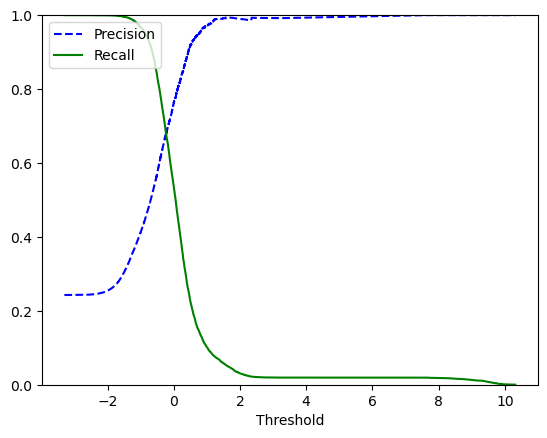

In [142]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plot_precision_recall_vs_threshold(precisions_sgd, recalls_sgd, thresholds_sgd)
plt.show()

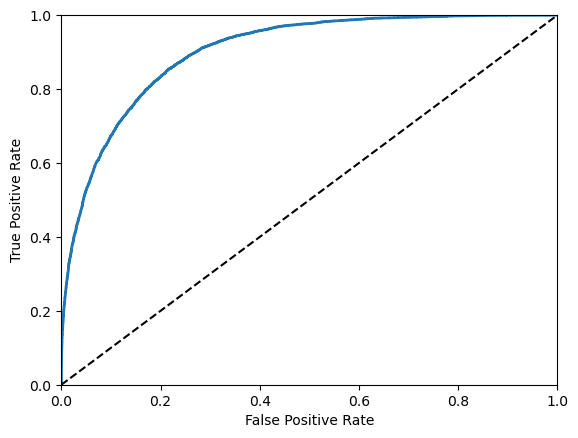

In [46]:
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_10, y_10_scores_sgd)
plot_roc_curve(fpr_sgd, tpr_sgd)
plt.show()

## Let's now compare it to Logistic Regression 

In [55]:
lg_clf = LogisticRegression(max_iter=500, C = 100)
lg_clf.fit(X_10, y_10)

LogisticRegression(C=100, max_iter=500)

In [56]:
print(lg_clf.predict([X_10.iloc[2]]), y_10.iloc[2])

[0] 0


/Users/nadiiaduiunova/opt/anaconda3/envs/final_env/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [57]:
cross_val_score(lg_clf, X_10, y_10, cv=3, scoring="f1_macro")

array([0.77494455, 0.78453685, 0.78904348])

In [58]:
y_10_pred_lg = cross_val_predict(lg_clf, X_10, y_10, cv=3)
confusion_matrix(y_10, y_10_pred_lg)

array([[23049,  1670],
       [ 3152,  4689]])

In [144]:
print(classification_report(y_10, y_10_pred_lg))

ValueError: Found input variables with inconsistent numbers of samples: [26048, 32560]

In [59]:
y_10_scores_lg = lg_clf.decision_function([X_10.iloc[90]])
y_10_scores_lg

/Users/nadiiaduiunova/opt/anaconda3/envs/final_env/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0.52646442])

In [60]:
y_10_scores_lg = cross_val_predict(lg_clf, X_10, y_10, cv=3, method="decision_function")
precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_10, y_10_scores_lg)

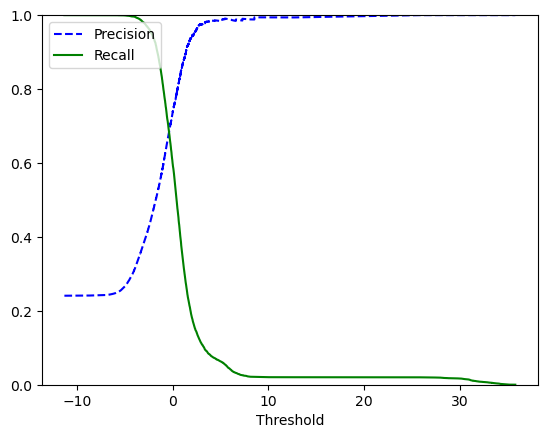

In [61]:
plot_precision_recall_vs_threshold(precisions_lg, recalls_lg, thresholds_lg)
plt.show()

In [62]:
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_10, y_10_scores_lg)

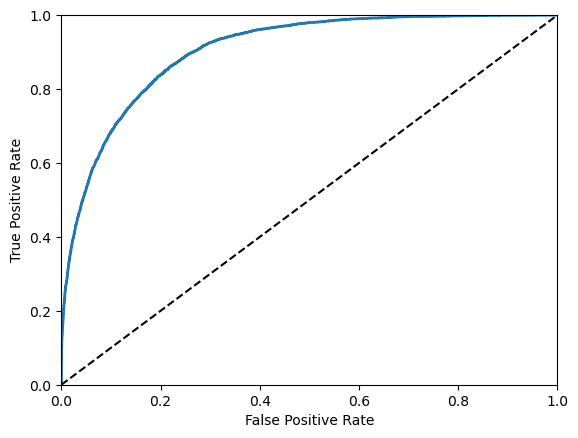

In [63]:
plot_roc_curve(fpr_lg, tpr_lg)
plt.show()

# Now let's try Random Forest classifier model

In [102]:
forest_clf = RandomForestClassifier(criterion = 'entropy', class_weight = 'balanced')
y_probas_forest = cross_val_predict(forest_clf, X_10, y_10, cv=3, method="predict_proba")

In [103]:
y_scores_forest = y_probas_forest[:, 1] # score = probability of positive class 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_10, y_scores_forest)

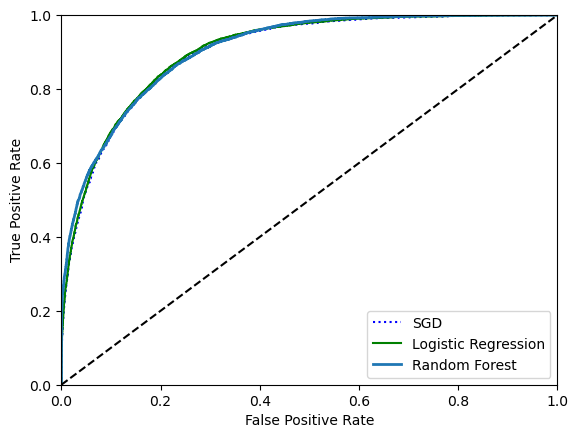

In [93]:
plt.plot(fpr_sgd, tpr_sgd, "b:", label="SGD")
plt.plot(fpr_lg, tpr_lg, "g-", label="Logistic Regression")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="best")
plt.show()

In [107]:
forest_clf.fit(X_10, y_10)
y_pred_forest = cross_val_predict(forest_clf, X_10, y_10, cv = 3)

In [108]:
confusion_matrix(y_10, y_pred_forest)

array([[23086,  1633],
       [ 3026,  4815]])

In [106]:
cross_val_score(forest_clf, X_10, y_10, cv=5, scoring="f1_macro")

array([0.78737315, 0.78724609, 0.79882682, 0.79121505, 0.79073895])

# KNN classifier

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_10, y_10)

In [ ]:
y_10_pred_knn = cross_val_predict(knn_clf, X_10, y_10, cv=3)


In [ ]:
confusion_matrix(y_10, y_10_pred_knn)

# Support Vector Machine classifier with polynomial kernel

In [520]:
poly_kernel_svm_clf = SVC(C = 10, gamma = 0.1, kernel = 'rbf')

In [521]:
poly_kernel_svm_clf.fit(X_10, y_10)

SVC(C=10, gamma=0.1)

In [522]:
y_10_pred_svm = cross_val_predict(poly_kernel_svm_clf, X_10, y_10, cv=3)

In [523]:
confusion_matrix(y_10, y_10_pred_svm)

array([[23243,  1476],
       [ 3438,  4403]])

In [525]:
print(classification_report(y_10, y_10_pred_svm))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     24719
           1       0.75      0.56      0.64      7841

    accuracy                           0.85     32560
   macro avg       0.81      0.75      0.77     32560
weighted avg       0.84      0.85      0.84     32560



In [15]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01], 'C': [1, 10, 100]},
    {'kernel': ['poly'], 'degree': [7, 14, 28], 'coef0': [0.1, 1,10], 'C': [1, 10, 100]},
]
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5, refit = True)
grid_search.fit(X_10, y_10)

In [518]:
grid_search.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [519]:
grid_search.best_estimator_

SVC(C=10, gamma=0.1)

In [186]:
pca = PCA(n_components=37)
X2D = pca.fit_transform(X_10)

In [187]:
y_10_pred_pca = cross_val_predict(LogisticRegression(), X2D, y_10, cv=3)

In [188]:
print(classification_report(y_10, y_10_pred_pca))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     24719
           1       0.73      0.58      0.65      7841

    accuracy                           0.85     32560
   macro avg       0.80      0.76      0.78     32560
weighted avg       0.84      0.85      0.84     32560



In [189]:
print(pca.explained_variance_ratio_)

[1.66108865e-01 1.11447728e-01 8.58859485e-02 6.50000039e-02
 5.70776812e-02 5.50656724e-02 5.34350151e-02 5.04040941e-02
 4.54476229e-02 4.20995471e-02 3.03098022e-02 2.97882420e-02
 2.31254227e-02 2.15963660e-02 1.95085788e-02 1.64077237e-02
 1.59012577e-02 1.41475416e-02 1.36368753e-02 1.27372837e-02
 1.22870434e-02 1.18620422e-02 8.23311740e-03 7.86926243e-03
 6.18101811e-03 4.89610707e-03 4.41488476e-03 3.71084459e-03
 3.60199934e-03 2.28761703e-03 2.14906833e-03 2.03170490e-03
 9.26333885e-04 1.98291428e-04 1.25468947e-04 9.39243678e-05
 1.90705079e-29]


In [190]:
X_10

,ordinal__Education,minmax_scaler__Age,minmax_scaler__final weight,minmax_scaler__Capital Gain,minmax_scaler__Capital Loss,minmax_scaler__Hours per week,onehot__Workclass_ Federal-gov,onehot__Workclass_ Local-gov,onehot__Workclass_ Never-worked,onehot__Workclass_ Private,...,onehot__Occupation_ Tech-support,onehot__Occupation_ Transport-moving,onehot__Relationship_ Other-relative,onehot__Ethnic group_ Asian-Pac-Islander,onehot__Ethnic group_ Black,onehot__Ethnic group_ Other,onehot__Ethnic group_ White,onehot__Sex_ Male,onehot__Country_Developed,onehot__Country_Developing
0,0.800000,0.301370,0.044302,0.021740,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,0.800000,0.452055,0.048238,0.000000,0.0,0.122449,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,0.533333,0.287671,0.138113,0.000000,0.0,0.397959,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,0.400000,0.493151,0.151068,0.000000,0.0,0.397959,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.800000,0.150685,0.221488,0.000000,0.0,0.397959,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,0.733333,0.136986,0.166404,0.000000,0.0,0.377551,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
32556,0.533333,0.315068,0.096500,0.000000,0.0,0.397959,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
32557,0.533333,0.561644,0.094827,0.000000,0.0,0.397959,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
32558,0.533333,0.068493,0.128499,0.000000,0.0,0.193878,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [207]:
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline

from sklearn.decomposition import KernelPCA

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
])
param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
        }]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_10, y_10)

print(grid_search.best_params_)

{'kpca__gamma': 0.03, 'kpca__kernel': 'sigmoid'}
